**Tutorial 7 - Photometric redshifts.**

In this tutorial we will try to builds models to predict galaxy redshifts from their photometry in 5 bands.

We will get some practice with the scikit-learn package which contains powerful tools for simple machine learning problems. (https://scikit-learn.org/stable/user_guide.html)

1) Import the data from the file reduced_galaxy_data.fits.  This file contains a small subset of data from the Slone Digital Sky Survey.  The columns in the fits table are: id number, the measured spectroscopic redshift, the fluxes in five bands (ugriz), and the magnitudes in the same five bands.  Note that the entry in the flux and magnitude columns is an array of 5 entries.

Put the redshifts into an array called `redshift` and the magnitudes into am two dimensional array `color_block` where `color_block[0]` are the 5 magnitudes for the first entry.

Make a scatter plot of redshift versus u band magnitude.

In [8]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd

filename = "reduced_galaxy_data.fits"
hdul = fits.open(filename)
#print(hdul)
print('shape  ',hdul[1].columns)

data = hdul[1].data     #estrae dati da file

#print(np.shape(hdul[1].data))   #.data per accedere a dati



redshift = np.array(data['z']) #redshift da dati

color_block = np.array(data['magnitudes']) # U B V R I

fluxes =  data['fluxes']

#U_magnitude = magnitudes[:,0] #così accedo alla colonna
                               #per accedere a riga [0,:]

#print('shape of color block[0] :\n',np.shape(color_block[0]))
print('shape of color block:\n',np.shape(color_block))

#print(np.shape(redshift))



shape   ColDefs(
    name = 'OBJID'; format = '22A'
    name = 'Z'; format = 'E'
    name = 'MAGNITUDES'; format = '5E'; dim = '(5)'
    name = 'FLUXES'; format = '5E'; dim = '(5)'
)
shape of color block:
 (35917, 5)


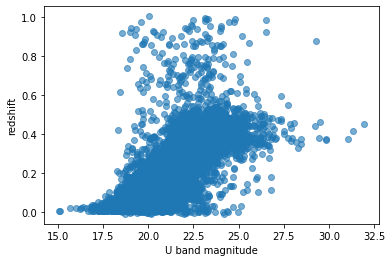

In [9]:

plt.scatter(color_block[:,0],redshift, alpha=.6)
plt.ylabel('redshift')
plt.xlabel('U band magnitude')
plt.show()

2) Subtract the U band magnitude from all the other bands so that we have 4 colors and one apparent magnitude.

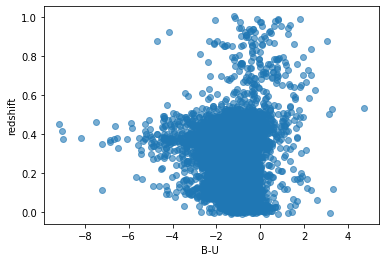

In [10]:

for i in np.arange(1,5) :
    color_block[:,i] = color_block[:,i] - color_block[:,0]



#B - U
#V - U
#R - U
#I - U
plt.scatter(color_block[:,1],redshift, alpha=.6)
plt.ylabel('redshift')
plt.xlabel('B-U ')
plt.show()

3) From sklearn import `linear_model`.  Make a `linear_model.LinearRegression(copy_X=True)` object 
and then fit a model that predicts redshifts from the colors. (see https://scikit-learn.org/stable/modules/linear_model.html for more information.)  Print out the coefficients.  Use the model.score() function to give the score for the model which in this case is the R^2 statistic (coefficient of determination).

In [11]:
from sklearn import linear_model
#from sklearn.model_selection import train_test_split

reg = linear_model.LinearRegression(copy_X=True) #creo oggetto

lin_reg = reg.fit(color_block, redshift)

print('coefficents: \n',lin_reg.coef_,'\n', 'score:', lin_reg.score(color_block, redshift))

coefficents: 
 [ 0.05516343  0.16267088 -0.02181361 -0.08249151  0.0119597 ] 
 score: 0.6903514773206605


4) Use the model to predict the redshifts for all of the galaxies.  Make a scatter plot of the predicted vs observed redshifts. Decreasing the alpha parameter can make this clearer.

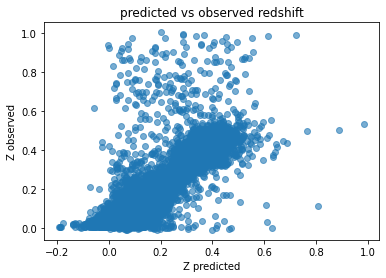

In [12]:

# predict redshifts
Z_pred = reg.predict(color_block)

#print(np.shape(Z_pred))
# plot prediction vs redshifts

#retta di confronto

plt.scatter(Z_pred, redshift, alpha=.6)
plt.title('predicted vs observed redshift')
plt.xlabel('Z predicted')
plt.ylabel('Z observed')
plt.show()


5) Scatter plots can be deceiving.  The density of points can be estimated with a Gaussian kernel.  This should do that.  Put some labels on the plot and overlay a contour plot.  (If you can make a nicer countour plot than this extra point.)

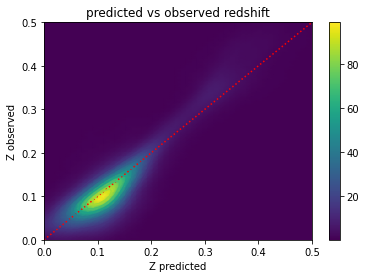

In [13]:
from scipy.stats import kde

#Z_pred = reg.predict(color_block[:,1].reshape(-1,1))

nbins = 50
#k = kde.gaussian_kde(np.array([predictions,observations]))
k = kde.gaussian_kde(np.array([Z_pred,redshift]))

xi, yi = np.mgrid[0:0.5:nbins*1j, 0:0.5:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi,yi, zi.reshape(xi.shape), shading='gouraud') #this already is the final product

plt.plot([0,0.5],[0,0.5],linestyle=':', color='r')
plt.colorbar()

plt.contour(xi, yi, zi.reshape(xi.shape) ) #just to add more clear boundaries

plt.title('predicted vs observed redshift')
plt.xlabel('Z predicted')
plt.ylabel('Z observed')
plt.show()

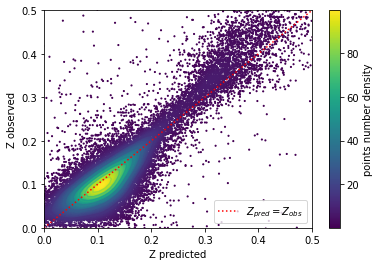

In [14]:
#MY ATTEMPT TO DO A BETTER SCATTER PLOT
#ITS TAKE LONGER BUT IT'S BETTER-LOOKING at least to me

from matplotlib.colors import Normalize 
from matplotlib import cm

#calculate the point density
xy = np.vstack([Z_pred,redshift])
zz = kde.gaussian_kde(xy)(xy)

#Sort the points by density, so that the densest points are plotted last
idx = zz.argsort()

a,b,c = Z_pred[idx], redshift[idx], zz[idx]


plt.scatter(a, b, c=c, s=5, marker='.')
plt.xlim([0.,.5])
plt.ylim([0.,.5])
plt.xlabel('Z predicted')
plt.ylabel('Z observed')

#add the contours
plt.contour(xi, yi, zi.reshape(xi.shape))


norm = Normalize(vmin = np.min(c), vmax = np.max(c))
cbar = plt.colorbar(cm.ScalarMappable(norm = norm))
cbar.set_label('points number density')

plt.plot([0,0.5],[0,0.5],linestyle=':', color='r',label='$Z_{pred} = Z_{obs}$')

plt.legend()
plt.show()




6) We are going to need a quick way of assessing how well a model is working.

Make a function that takes the residuals (predictions - true values) and prints six things : 1) their median, 2) mean, 3) the range the contains 90% of the cases with 5% larger and smaller, 4) the same for 80%, 5) the standard deviation and 6) the mean absolute deviation.  

Call this function `report()`.

In [15]:
def report(residuals) :

    median = np.median(residuals)

    mean = np.mean(residuals)

    std = np.std(residuals)

    N90 = np.quantile(residuals,[0.05,0.95])

    N80 = np.quantile(residuals, [0.1, 0.9])

    dev = np.sum(abs(residuals-mean))/len(residuals)

    print('mean =', mean, '\n','median =', median ,'\n', 'std =', std,)
    print( '90% =', N90, '\n', '80% =', N80, '\n', 'mean absolute dev:', dev)
    
   
    return 
  


7) We need a quick way of calculating the residuals, but we cannot calculate the residuals on the same data as we fit the model.  Let's make a function the splits the data in two, fits on one subset and calculates the residuals on the remaining subset.

The function should take the independent variables `X`, the dependent variable `Y`, the model `model` and the fraction of the data set that will be used for fitting the the model.  The `model` has the functions `fit()` and `predict()` as for the sklearn models.  The function should split the data set into two random subsets: fit and test.  It should then fit the model and then return the residuals for the test set and the true Y values of the test set.

In [16]:
def test_residuals(X,Y,model,fit_fraction) :
   
    # make and index da 0 al num di  residui che ho
    N = len(X)
    index = np.arange(0, N)
    # shuffle the index
    np.random.shuffle(index)
    
    #split the index into two parts 
    
    split = int(fit_fraction*N)
    index_fit = index[:split]
    index_test = index[split:]

    # define X_fit,Y_fit
    X_fit = X[index_fit]
    Y_fit = Y[index_fit]

    # define X_test, Y_test
    X_test = X[index_test]
    Y_test = Y[index_test]

    ## fit model
    model.fit(X_fit, Y_fit)
   
    ## predict redshifts
    Y_pred = model.predict(X_test)

    residual = Y_pred-Y_test
   
    return residual, Y_test, Y_pred



8) Use your function `test_residuals()` to get a set of residuals with `linear_mod` and our data.  Use 80% of the data for fitting and 20% for testing. Run `report()` on the resulting residuals to see how well this model predicts the redshifts.

In [17]:
res, redshift_pred, Y_pred = test_residuals(color_block,redshift,lin_reg,0.8)

print('90% and 80% must be read as: from [value 1] to [value2]\n')
report(res)

90% and 80% must be read as: from [value 1] to [value2]

mean = -0.00013678287837370134 
 median = 0.001998484427520486 
 std = 0.06012214931477111
90% = [-0.06862103  0.07096715] 
 80% = [-0.04687739  0.05143468] 
 mean absolute dev: 0.03424035061196275


9) Make a nice histogram of the residuals.

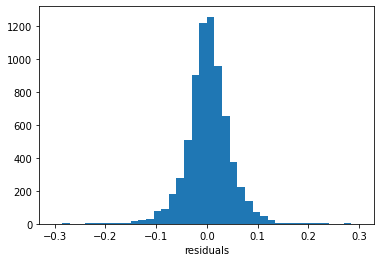

In [18]:
plt.hist(res, bins=40, range=(-.3,.3))
plt.xlabel('residuals')
plt.show()

10) What is important is that the fractional error in the redshift is small, i.e. `residuals / y`.  Find the fractional residuals, run them through `report` and make a histogram of them.

mean = -0.39472450380071855 
 median = 0.015568868182904363 
 std = 7.410845659636852
90% = [-1.31550304  0.55460295] 
 80% = [-0.56561333  0.41398671] 
 mean absolute dev: 0.8501902137086208


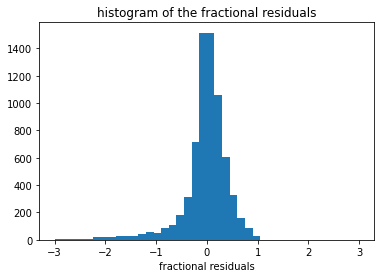

In [19]:
fract_res = res / abs(Y_pred)   

report(fract_res)

plt.hist(fract_res, bins = 40, range = (-3, 3))
plt.title('histogram of the fractional residuals')
plt.xlabel('fractional residuals')
plt.show()

11) Would you consider this a successful model in terms of the fractional residuals?

In [20]:
print('in terms of fractional residuals we can say that the model is not very accurate. \n a lot of predictions are totally inaccuarte ')



in terms of fractional residuals we can say that the model is not very accurate. 
 a lot of predictions are totally inaccuarte 


12) So far, the model has been linear in the parameters AND the colors/magnitude.  It might improve the model if we include terms in the model that are second order in the colors while keeping it linear in the parameters.

sklearn provides a convenient function that will transform our matrix of colors into a larger matrix that includes higher order terms.  In particular, `PolynomialFeatures(2).fit_transform(color_block)` will include all the colors squared and all the products of the colors.

Use this function to transform our `color_block` into another one with second order terms.

How many more parameters will be in a linear model fit with this new data matrix?

In [21]:
from sklearn.preprocessing import PolynomialFeatures

color_block2 = PolynomialFeatures(2).fit_transform(color_block)

print(np.shape(color_block2))


(35917, 21)


13) Create and fit a new linear model using this new data matrix.

What is the score for this model?

In [29]:
lin_reg2 = linear_model.LinearRegression(copy_X=True)

lin_reg2.fit(color_block2, redshift)
print('New score:',lin_reg2.score(color_block2,redshift))
print('the score of model II is higher so it must be a better model')

New score: 0.7438913853976372
the score of model II is higher so it must be a better model


14) Use your functions `test_residuals()` and `report()` with this new model as before.  Make a histogram of the residuals as before.

mean = 0.00021624537267590804 
 median = 0.0008305689682919226 
 std = 0.05057200201672407
90% = [-0.0552593   0.06020983] 
 80% = [-0.03540269  0.04149968] 
 mean absolute dev: 0.02754660687221663


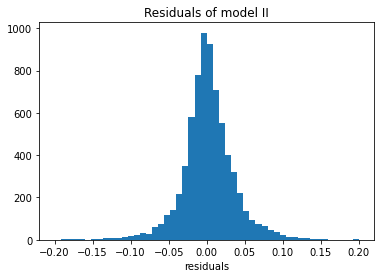

In [23]:
res2, true_res2, pred2 = test_residuals(color_block2, redshift, lin_reg2, 0.8)
report(res2)

plt.hist(res2, bins = 50, range = (-0.2, 0.2))
plt.title('Residuals of model II')
plt.xlabel('residuals')
plt.show()

15) As before, do the same for the fractional residuals.

mean = 2.6974295519867106 
 median = 0.005839167697462312 
 std = 205.874230511702
90% = [-0.35206209  1.20937293] 
 80% = [-0.24236267  0.65142904] 
 mean absolute dev: 5.125714583849179


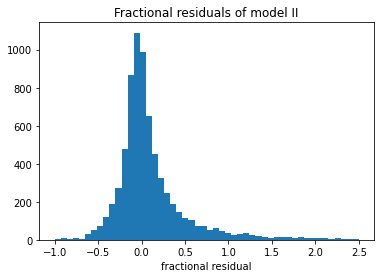

In [24]:
fract_res2 = res2 / true_res2
report(fract_res2)
plt.hist(fract_res2, bins = 50, range = (-1., 2.5))
plt.title('Fractional residuals of model II')
plt.xlabel('fractional residual')
plt.show()

16) Make a new contour plot for predictions based on `color_block2`.

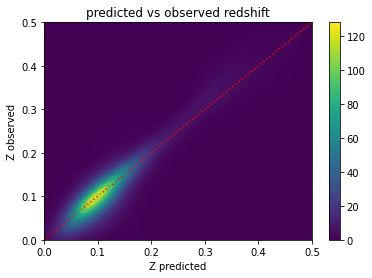

In [25]:
y_pred_poli = res2 + true_res2

## Making contour plot


#k = kde.gaussian_kde(np.array([predictions,observations]))
k2 = kde.gaussian_kde(np.array([y_pred_poli, true_res2]))

xi2, yi2 = np.mgrid[0:0.5:nbins*1j, 0:0.5:nbins*1j]
zi2 = k2(np.vstack([xi2.flatten(), yi2.flatten()]))
 
plt.pcolormesh(xi2, yi2, zi2.reshape(xi2.shape), shading='gouraud')
plt.plot([0,0.5], [0,0.5], linestyle=':', color='r')
plt.colorbar()

plt.contour(xi2, yi2, zi2.reshape(xi2.shape) )
plt.title('predicted vs observed redshift')
plt.xlabel('Z predicted')
plt.ylabel('Z observed')
plt.show()

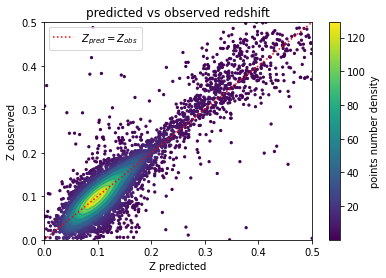

In [26]:
#calculate the point density
xy = np.vstack([y_pred_poli,true_res2])
zz = kde.gaussian_kde(xy)(xy)

#Sort the points by density, so that the densest points are plotted last
idx = zz.argsort()

a,b,c = y_pred_poli[idx], true_res2[idx], zz[idx]


plt.scatter(a, b, c=c, s=20, marker='.')
plt.xlim([0.,.5])
plt.ylim([0.,.5])
plt.xlabel('Z predicted')
plt.ylabel('Z observed')

#add the contours
plt.contour(xi2, yi2, zi2.reshape(xi2.shape))

plt.plot([0,0.5],[0,0.5],linestyle=':', color='r',label='$Z_{pred} = Z_{obs}$')

norm = Normalize(vmin = np.min(c), vmax = np.max(c))
cbar = plt.colorbar(cm.ScalarMappable(norm = norm))
cbar.set_label('points number density')

plt.title('predicted vs observed redshift')
plt.legend()
plt.show()

17) Uses `sklearn.model_selection.cross_val_score` to find an estimate of the mean absolute error using k-fold validation. (scoring="neg_mean_absolute_error", cv=5)

In [27]:
from sklearn.model_selection import cross_val_score

score2 = cross_val_score(lin_reg2, color_block2, redshift, scoring='neg_mean_absolute_error', cv=5)

score1 = cross_val_score(lin_reg, color_block, redshift, scoring='neg_mean_absolute_error', cv=5)

print('mean absolute error for model I:', abs(np.mean(score1)))
print('mean absolute error for model II :', abs(np.mean(score2)))

mean absolute error for model I: 0.03377666625556823
mean absolute error for model II : 0.028637003103396192


18) Is this model an improvement on the first one?

In [28]:
print('the mean absolute error from model II is smaller, that means the model makes better predictions')

the mean absolute error from model II is smaller, that means the model makes better predictions
